In [396]:
import numpy as np
import matplotlib.pyplot as plt
import math
from bitarray import bitarray

ruleNr = 170
layerWidth = 50
generations = 100
startingPoint = 'center'
propagationStyle = 'impulse'

def oldApproach(curLayer, ruleBinary):
    return ruleBinary[
        7 - np.sum(
            np.vstack((
                np.roll(curLayer, 1)*4,
                curLayer*2,
                np.roll(curLayer, -1)
            )),
            axis=0
        )
    ]

def nextLayer(curLayer, ruleBinary):
    output = np.array([0 for i in range(len(curLayer))])
    array = 7 - np.sum(np.vstack((np.roll(curLayer, 1)*4,curLayer*2,np.roll(curLayer, -1))), axis=0)
    for i in range(len(array)):
        if ruleBinary[array[i]] == 1:
            output[i] = 1
        else:
            output[i] = 0
    
    return output

def nextLayer2(curLayer, ruleBinary):
    output = np.array([0 for i in range(len(curLayer))])
    array = 31 - np.sum(np.vstack((np.roll(curLayer, 2)*16, np.roll(curLayer, 1)*8, 
                                   curLayer*4, np.roll(curLayer, -1)*2, np.roll(curLayer, -2))), axis=0)
    for i in range(len(array)):
        if ruleBinary[array[i]] == 1:
            output[i] = 1
        else:
            output[i] = 0
    
    return output

def nextLayer3(curLayer, ruleBinary):
    output = np.array([0 for i in range(len(curLayer))])
    array = 127 - np.sum(np.vstack((np.roll(curLayer, 3)*64, np.roll(curLayer, 2)*32, 
                                    np.roll(curLayer, 1)*16, curLayer*8, np.roll(curLayer, -1)*4, 
                                    np.roll(curLayer, -2)*2, np.roll(curLayer, -3))), axis=0)
    for i in range(len(array)):
        if ruleBinary[array[i]] == 1:
            output[i] = 1
        else:
            output[i] = 0
    
    return output

In [397]:
ruleNrError = "rule number should be an integer from 0 to 255 inclusive"
layerWidthError = "layer width should be an integer from 10 to 200 inclusive"
generationsError = "number of generations should be an integer from 1 to 10000 inclusive"
startingPointError = "starting point should be set to 'left', 'right' or 'center'"
propagationStartError = "propagation style should be set to 'impulse' or 'random'"
langtonError = "rule number should be an integer from 0 to 4294967295 inclusive"

In [398]:
def simulate(ruleNr, layerWidth, generations, startingPoint, propagationStyle, radius):
#     assert 0 <= ruleNr <= 255, ruleNrError
    assert 10 <= layerWidth <= 200, layerWidthError
    assert 1 <= generations <= 10000, generationsError
    assert startingPoint in ['left', 'right', 'center'], startingPointError
    assert propagationStyle in ['impulse', 'random'], propagationStartError
    
    if radius == 1:
        ruleBinary = np.array([int(digit) for digit in '{:08b}'.format(ruleNr)])
    elif radius == 2:
        ruleBinary = np.array([0 for i in range(32)])
        value = '{:32b}'.format(30)
        for i in range(len(ruleBinary)):
            if value[i] == " " or value[i] == "0":
                ruleBinary[i] = 0
            else:
                ruleBinary[i] = 1

    propagationField = np.zeros([generations, layerWidth], dtype=np.int8)
    
    if propagationStyle == 'random':
        propagationField[0, :] = np.array(np.random.rand(layerWidth) < 0.5, dtype=np.int8)
    else:
        if startingPoint == 'left':
            propagationField[0, 0] = 1
        elif startingPoint == 'right':
            propagationField[0, layerWidth - 1] = 1
        else:
            propagationField[0, layerWidth//2] = 1
        
    for i in range(generations - 1):
        if radius == 1:
            propagationField[i + 1, :] = nextLayer1(propagationField[i, :], ruleBinary)
        elif radius == 2:
            propagationField[i + 1, :] = nextLayer2(propagationField[i, :], ruleBinary)
        elif radius == 3:
            propagationField[i + 1, :] = nextLayer3(propagationField[i, :], ruleBinary)
    
    return propagationField

In [399]:
propagationField = simulate(ruleNr, layerWidth, generations, startingPoint, propagationStyle, 1)

In [400]:
def getEntropy(radius, rule_book):
    propagationField = simulate(ruleNr, layerWidth, 200, startingPoint, propagationStyle, 1)
    nrOfOnes = sum(sum(propagationField[100:200, :]))
    nrOfZeros = 100*layerWidth - nrOfOnes
    onesProb = nrOfOnes/(100*layerWidth)
    zerosProb = 1 - onesProb
    if onesProb == 0 or onesProb == 1:
        return 0
    return -(nrOfOnes*onesProb*math.log2(onesProb) + nrOfZeros*zerosProb*math.log2(zerosProb))/(layerWidth*10)

In [401]:
def getLangton(radius, rule_book):
    assert 0 <= rule_book <= 4294967296, langtonError
    result = 0
    if rule_book < 256:
        return sum(np.array([int(digit) for digit in '{:08b}'.format(ruleNr)]))/8
    else:
        for i in '{:32b}'.format(rule_book):
            if i == '1':
                result += 1
        return result/32

0.5
0.3024969284730954


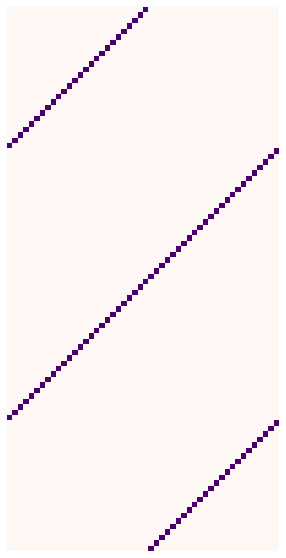

In [402]:
print(getLangton(1, 110))
print(getEntropy(1, 110))
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.set_axis_off()
ax.imshow(propagationField, interpolation='none', cmap='RdPu')

In [403]:
def returnString(array):
    arr = list(array.flatten())
    strings = [str(x) for x in arr] 
    
    return ' '.join(strings)

def sumEntropy(line):
    struct = {}
    lineSize = line.size
    key = returnString(line[0:5])
    struct[key] = 1
    
    for i in range(lineSize - 1):
        line = np.roll(line, -1)
        key = returnString(line[0:5])
        if not key in struct:
            struct[key] = 1
        else: struct[key] += 1
            
    print(struct)
    print(len(struct))
    sum = 0
    for val in struct.values():
        sum += val
    print(sum)
    difKeys = len(struct)
    entropy = 0
    for key in struct:
        entropy += struct[key]*math.log(struct[key]/lineSize, 2)
        
    return -entropy

ruleBinary = np.array([int(digit) for digit in '{:08b}'.format(ruleNr)])

def newEntropy():
    lastLine = propagationField[propagationField.shape[0] - 1, :]
    return sumEntropy(ruleBinary)

ent = newEntropy()
print(ent)

{'1 0 1 0 1': 4, '0 1 0 1 0': 4}
2
8
8.0
